Based on the course _Elements of Data Science_ from the [AWS Certified Machine Learning](https://aws.amazon.com/training/learning-paths/machine-learning/) program and [The Interactive Data Science Tutorial](https://www.kaggle.com/helgejo/an-interactive-data-science-tutorial), this notebook summarizes the ML workflow and provides a template as a starting guide to a new project.

Imports

In [1]:
# data analysis and wrangling
import pandas as pd
import pickle

# model selection
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

Loading preprocessed datasets from "processing.ipynb"

In [2]:
titanic = pickle.load(open('data/titanic_preprocessed.pkl', 'rb'))
titanic.head()

,Age,Cabin,Fare,Name,Parch,PassengerId,Sex,SibSp,Survived,Ticket,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,22.0,U,7.2500,"Braund, Mr. Owen Harris",0,1,1,1,0.0,A/5 21171,0,0,1,0,0,1
1,38.0,C85,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,0,1,1.0,PC 17599,1,0,0,1,0,0
2,26.0,U,7.9250,"Heikkinen, Miss. Laina",0,3,0,0,1.0,STON/O2. 3101282,0,0,1,0,0,1
3,35.0,C123,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,0,1,1.0,113803,0,0,1,1,0,0
4,35.0,U,8.0500,"Allen, Mr. William Henry",0,5,1,0,0.0,373450,0,0,1,0,0,1


# Feature engineering

From the AWS ML content:

_Creating novel features to use as inputs for ML models using domain and data knowledge, e.g. squaring (transformation), multiplication (combination of attributes)._

**rule of thumb**: create as many features then apply dimensionality reduction (if needed).

See [sklearn.feature_extraction](https://scikit-learn.org/stable/modules/feature_extraction.html)

## Transformation

Sometimes polynomial is better. See sklearn.preprocessing.PolynomialFeatures.

Beware
- Overfitting (if degree too high)
- Consider non-polynomial (e.g. log, sigmoid) transformation
- Risk of extrapolation beyond range of the data
- Radial Basis Function widely used by SVM

### Calculate family size

In [3]:
# Includes the passenger
family = pd.DataFrame()
family['FamilySize'] = titanic['Parch'] + titanic['SibSp'] + 1
family.head()

,FamilySize
0,2
1,2
2,1
3,2
4,1


## Filtering

Motivation: select relevant features, e.g. remove channels from image if color is not important.

### Extract the cabin type

In [4]:
# From the Kaggle notebook: we grab the first letter of the cabin
# which denotes the cabin type and create a one-hot encoding feature.

cabin = pd.DataFrame()
cabin['Cabin'] = titanic['Cabin'].map(lambda c: c[0])
cabin = pd.get_dummies(cabin['Cabin'], prefix='Cabin')
cabin.head()

,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U
0,0,0,0,0,0,0,0,0,1
1,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1
3,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1


### Extract the title

Which could be related to social and economic status. Taken from the Kaggle notebook referenced at the top of this document.

Make sure everyone has a lastname preprended.

In [5]:
titanic.Name.map(lambda name: len(name.split(', '))).value_counts()

2    1309
Name: Name, dtype: int64

In [6]:
fnames = titanic.Name.map(lambda name: name.split(', ')[1])
fnames.head()

0                               Mr. Owen Harris
1    Mrs. John Bradley (Florence Briggs Thayer)
2                                   Miss. Laina
3            Mrs. Jacques Heath (Lily May Peel)
4                             Mr. William Henry
Name: Name, dtype: object

Make sure everyone has a title

In [7]:
fnames.map(lambda name: len(name.split('.'))).value_counts()

2    1308
3       1
Name: Name, dtype: int64

In [8]:
titles = fnames.map(lambda name: name.split('.')[0])
titles.value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Dr                8
Rev               8
Col               4
Ms                2
Major             2
Mlle              2
the Countess      1
Lady              1
Don               1
Capt              1
Dona              1
Mme               1
Jonkheer          1
Sir               1
Name: Name, dtype: int64

In [9]:
title_categories = {
    "Capt":         "Officer",
    "Col":          "Officer",
    "Major":        "Officer",
    "Jonkheer":     "Royalty",
    "Don":          "Royalty",
    "Sir" :         "Royalty",
    "Dr":           "Officer",
    "Rev":          "Officer",
    "the Countess": "Royalty",
    "Dona":         "Royalty",
    "Mme":          "Mrs",
    "Mlle":         "Miss",
    "Ms":           "Mrs",
    "Mr" :          "Mr",
    "Mrs" :         "Mrs",
    "Miss" :        "Miss",
    "Master" :      "Master",
    "Lady" :        "Royalty"
}

title = pd.DataFrame()
title['Title'] = titles.map(title_categories)
title = pd.get_dummies(title.Title)
title.head()

,Master,Miss,Mr,Mrs,Officer,Royalty
0,0,0,1,0,0,0
1,0,0,0,1,0,0
2,0,1,0,0,0,0
3,0,0,0,1,0,0
4,0,0,1,0,0,0


In [10]:
titanic['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

## Cleanup

In [11]:
# Cabin is already covered by the one-hot encoded Cabin_* columns
titanic.drop(['Cabin'], axis=1, inplace=True)
# PassengerId has not proved to add to the model
titanic.drop(['PassengerId'], axis=1, inplace=True)
# From Name we already extracted the title
titanic.drop(['Name'], axis=1, inplace=True)

titanic.drop(['Ticket'], axis=1, inplace=True)

## Assemble

In [12]:
titanic = pd.concat([titanic, title, cabin, family], axis=1)
titanic.head()

,Age,Fare,Parch,Sex,SibSp,Survived,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,...,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,FamilySize
0,22.0,7.2500,0,1,1,0.0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,2
1,38.0,71.2833,0,0,1,1.0,1,0,0,1,...,0,0,1,0,0,0,0,0,0,2
2,26.0,7.9250,0,0,0,1.0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1
3,35.0,53.1000,0,0,1,1.0,0,0,1,1,...,0,0,1,0,0,0,0,0,0,2
4,35.0,8.0500,0,1,0,0.0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1


In [13]:
titanic.columns

Index(['Age', 'Fare', 'Parch', 'Sex', 'SibSp', 'Survived', 'Embarked_C',
       'Embarked_Q', 'Embarked_S', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Master', 'Miss', 'Mr', 'Mrs', 'Officer', 'Royalty', 'Cabin_A',
       'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G',
       'Cabin_T', 'Cabin_U', 'FamilySize'],
      dtype='object')

## Scaling

Many algorithms (e.g. SGD and KNN) are sensible to features being on different scales, e.g. on housing prices #BR vs area vs price. Scaled ($\sigma_x = 1$) and centered values ($\mu_x = 0$) are more efficient to converge!

Note that decision trees and random forests *are not* sensitive to different scales.

**Important**: use a scaler on training data only.

Scaling is for one column, normalizing is for one variable.

**Mean/variance standardization**

\begin{equation}
{\displaystyle X_{i,j}={\frac {X_j - \mu_x}{\sigma_x} }}
\end{equation}

**MinMax scaling**

\begin{equation}
{\displaystyle X_i={\frac {X_i - X_{min}}{X_{max} - X_{min}} }}
\end{equation}

See [sklearn.preprocessing.StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

**Normalizer**

Rescales $X_j$ to unit norm based on L1 norm, L2 norm, Max norm.

\begin{equation}
{\displaystyle X_{i,j}={\frac {X_j - \mu_x}{\sigma_x} }}
\end{equation}

See [sklearn.preprocessing.Normalizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html)


## Text-based features

Use a bag-of-words model:  
From document to a vector of numbers, one for each word e.g. tokenize, count (term frequency), and normalize.

## Create datasets

In [14]:
has_survival_feature = titanic[titanic.Survived.notnull()]
train_valid_X = has_survival_feature[has_survival_feature.columns.difference(['Survived'])]
train_valid_y = has_survival_feature.Survived
test_X = titanic[titanic.Survived.isnull()].drop(['Survived'], axis=1)

train_X, valid_X, train_y, valid_y = train_test_split(train_valid_X, train_valid_y, train_size=.7)

print('complete set', titanic.shape)
print('training set', train_X.shape, train_y.shape)
print('validation set', valid_X.shape, valid_y.shape)
print('testing set', test_X.shape)

complete set (1309, 28)
training set (623, 27) (623,)
validation set (268, 27) (268,)
testing set (418, 27)


/home/ro/anaconda2/envs/deep/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## Feature importance

Decision Trees can be used to assess feature importance. Recall that the trees are cut starting with features providing the maximum information gain.

0.988764044944


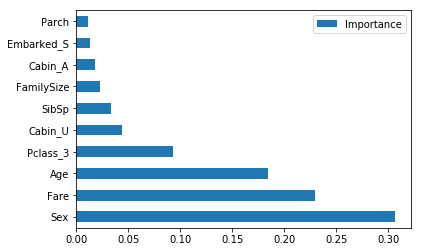

In [15]:
%matplotlib inline

def plot_variable_importance(X, y):
    tree = DecisionTreeClassifier(random_state=99)
    tree.fit(X, y)
    plot_model_var_imp(tree, X, y)
    
def plot_model_var_imp(model, X, y):
    imp = pd.DataFrame(model.feature_importances_, columns=['Importance'], index=X.columns)
    imp = imp.sort_values(['Importance'], ascending=False)
    imp[:10].plot(kind='barh')
    print(model.score(X, y))
    
plot_variable_importance(train_X, train_y)

## Export datasets

In [16]:
training_X = pd.concat([train_X, valid_X])
training_y = pd.concat([train_y, valid_y])
training = pd.concat([training_X, training_y], axis=1)

with open('data/titanic_train_engineered.pkl', 'wb') as handle:
    pickle.dump(training, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('data/titanic_test_engineered.pkl', 'wb') as handle:
    pickle.dump(test_X, handle, protocol=pickle.HIGHEST_PROTOCOL)